HaRe
====

HaRe (Harassment Recognizer) is a command line tool and Python library to automatically detect harassment as it happens (real-time) with the help of machine learning techniques. In this notebook we will look at the Python library.

Basic usage: monitoring conversations
--------------------------------------------------------

The easiest way to use HaRe is by simply loading a pretrained HaRe model included with this repo in the models folder:

In [1]:
#from hare import load_pretrained
#moba_hare = load_pretrained('hare/pretrained/simple')

from hare import Hare
from hare.brain import DictBasedBrain

moba_hare = Hare()
moba_hare.brain = DictBasedBrain()
moba_hare.brain.bad_words = ['noob','newb','n00b','fag','loser']

You can then use this object to monitor conversations in progress. Let's start a conversation and ask HaRe to monitor it:

In [2]:
from hare import Conversation

convo = Conversation()
moba_hare.add_conversation(convo)

At any point in time, you can then request the current status of the conversation according to this HaRe model:

In [3]:
convo.add_utterance(speaker='a',content='hello')
convo.add_utterance(speaker='b',content='hi everyone')
moba_hare.get_status()

{'a': 0.0, 'b': 0.0}

You can also add multiple sentences at once (for example a whole conversation if it has already finished), and see what HaRe's best guess was at every moment in time.

In [4]:
from hare import Utterance

convo.add_utterances([Utterance(speaker='a',content='good luck'),
                      Utterance(speaker='c',content='ur all n00bs'),
                      Utterance(speaker='b',content='u are a loser yourself'),
                      Utterance(speaker='a',content='take it easy guys'),
                      Utterance(speaker='c',content='n00b')])

moba_hare.visualize_history_for_conversation()

a: hello
{'a': 0.0}
---

b: hi everyone
{'a': 0.0, 'b': 0.0}
---

a: good luck
{'a': 0.0, 'b': 0.0}
---

c: ur all n00bs
{'a': 0.0, 'b': 0.0, 'c': 0.25}
---

b: u are a loser yourself
{'a': 0.0, 'b': 0.25, 'c': 0.25}
---

a: take it easy guys
{'a': 0.0, 'b': 0.25, 'c': 0.25}
---

c: n00b
{'a': 0.0, 'b': 0.25, 'c': 0.5}
---



Or in a graph:

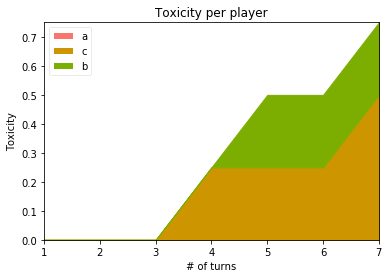

In [5]:
%matplotlib inline

from hare.visualize import visualize_toxicity_for_one_conversation
    
visualize_toxicity_for_one_conversation(moba_hare)

If you add multiple conversations for Hare to monitor, you will need to specify the conversation index when asking for the status:

In [6]:
second_convo = Conversation()

second_convo.add_utterance(speaker='a',content='hello')
second_convo.add_utterance(speaker='b',content='hi everyone')
second_convo.add_utterance(speaker='a',content='go away loser!')

moba_hare.add_conversation(second_convo)
moba_hare.get_status(id=1)

{'a': 0.25, 'b': 0.0}

Evaluating 
----------
If you have a labeled dataset (that is: for each conversation an indication which participants are considered toxic), HaRe can calculate to what extent its judgments match the labels. A label can range from the default 0 (not toxic at all) to 1 (maximally toxic). Let's label speaker c:

In [7]:
convo.label_speaker('c',1)
second_convo.label_speaker('a',0.9)

There are several evaluation metrics, depending on what is important to you (detecting ALL harassment, detecting harassment quickly, no false positives, etc). You can ask a HaRe object to output these aggregate scores directly, but we can also visualize them similar to how we visualized the estimates for a single conversation above. You can for example use these metrics to find out which HaRe object suits your goals best. 

Below we create two simple Hare objects that identify toxicity based on word lists.

In [8]:
from hare import Hare
from hare.brain import DictBasedBrain

insult_hare = Hare(name='insults')
insult_hare.brain = DictBasedBrain()
insult_hare.brain.bad_words = ['noob','newb','n00b','fag','loser']

swear_hare = Hare(name='swear_words')
swear_hare.brain = DictBasedBrain()
swear_hare.brain.bad_words = ['fuck','fck','fuk','shit','stfu','wtf','suck']

HaRe comes with ten fictional example conversations that are typical for a videogame environment. Let's give these to our two Hare objects to monitor.

In [9]:
from hare import load_example_conversations

example_conversations = load_example_conversations()
print('Loaded',len(example_conversations),'conversations')

for conversation in example_conversations:
    insult_hare.add_conversation(conversation)
    swear_hare.add_conversation(conversation)

Loaded 8 conversations


Now we have multiple labeled conversations and HaRe objects to analyze them, let's visualize how they perform:

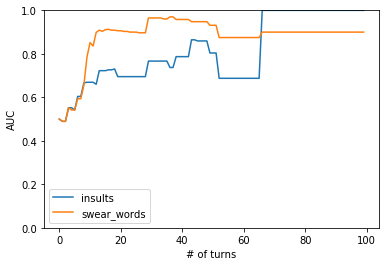

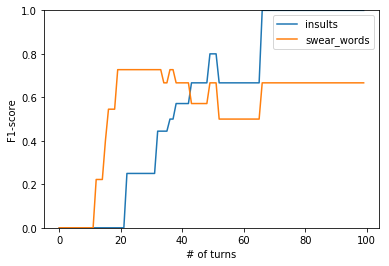

In [10]:
%matplotlib inline

%load_ext autoreload
%autoreload

from hare.visualize import visualize_accuracy_during_conversations, visualize_auc_during_conversations, visualize_fscore_during_conversations

visualize_auc_during_conversations([insult_hare,swear_hare])
visualize_fscore_during_conversations([insult_hare,swear_hare])

As expected, we see that the estimates are poor in the beginning of conversations, when there is almost no information, and that this gradually gets better as more people speak. Also note that scores can go down again over time, as more utterances also are more potential causes for confusion.

If you are only interested in how well this HaRe object is identifying toxic behavior afterwards, we can visualize scores over different thresholds; that is, how does it do when it focuses on preventing missing toxic speakers versus when it focuses on preventing false alarms.

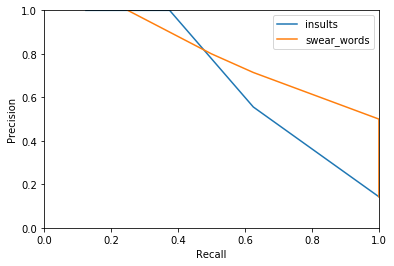

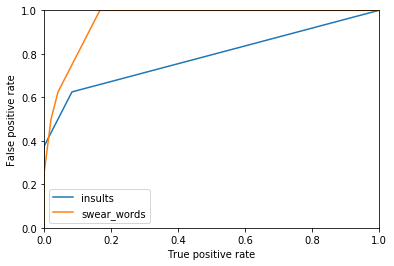

In [11]:
%matplotlib inline

from hare.visualize import visualize_retrospective_precision_and_recall, visualize_retrospective_roc_curve

visualize_retrospective_precision_and_recall([insult_hare,swear_hare])
visualize_retrospective_roc_curve([insult_hare,swear_hare])

Training
=======

If the existing pretrained models do not score high enough on your conversations, you can use train your own models. Before you cand do this, you need to select a 'brain', which is the classification algorithm HaRe will use under the hood. At the moment, neural networks with Bidirectional Gated Recurrent Units are popular for text classification, so we will use the `BiGruBrain`. This 'brain' uses the implementation in TensorFlow.

In [12]:
from hare import Hare
from hare.bigrubrain import BiGruBrain

custom_hare = Hare()
custom_hare.brain = BiGruBrain()

An interesting option for BiGruBrains (and potentially others) is that they allow you to add word embeddings, which you can see as general knowledge on the meaning of words, collected from large amounts of texts (like Wikipedia).

In [13]:
custom_hare.brain.embedding_location = '/vol/bigdata/word_embeddings/glove/glove.6B.50d.txt'

Now, all we need to do is add the conversation we want to train on, and we're ready to start training.

In [14]:
custom_hare.add_conversation(convo)
custom_hare.add_conversation(second_convo)

custom_hare.train()
custom_hare.save('name_of_folder')

Epoch 1/3
5/5 [==============================] - 2s 428ms/step - loss: 0.6731 - acc: 0.6000
Epoch 2/3
5/5 [==============================] - 0s 12ms/step - loss: 0.6230 - acc: 0.6000
Epoch 3/3
5/5 [==============================] - 0s 11ms/step - loss: 0.5951 - acc: 0.6000
